In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn

     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 9.5MB 39.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 3.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491625 sha256=03ff6493c9d45038d9f8bf3e3db69f60e6fd85e54a28cba90c233e5baf7dd1eb
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 92kB/s 
     |████████████████████████████████| 901kB 33.9MB/s 
     |████████████████████████████████| 10.1MB 21.9MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 3.9MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, b

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns 
import folium
import matplotlib.pyplot as plt
import math
import scipy
import statsmodels as sms
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
from sklearn.model_selection import train_test_split
import datetime
warnings.filterwarnings("ignore")
np.random.seed(32)

In [4]:
data = pd.read_csv('/content/drive/MyDrive/dataset/country_vaccinations.csv')
data.tail(10)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
15656,Zimbabwe,ZWE,2021-04-27,433939.0,370676.0,63263.0,22329.0,15562.0,2.92,2.49,0.43,1047.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15657,Zimbabwe,ZWE,2021-04-28,458013.0,388021.0,69992.0,24074.0,17860.0,3.08,2.61,0.47,1202.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15658,Zimbabwe,ZWE,2021-04-29,477597.0,400771.0,76826.0,19584.0,17971.0,3.21,2.70,0.52,1209.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15659,Zimbabwe,ZWE,2021-04-30,500342.0,414735.0,85607.0,22745.0,19194.0,3.37,2.79,0.58,1291.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15660,Zimbabwe,ZWE,2021-05-01,520299.0,428135.0,92164.0,19957.0,21171.0,3.50,2.88,0.62,1424.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15661,Zimbabwe,ZWE,2021-05-02,524199.0,430068.0,94131.0,3900.0,19169.0,3.53,2.89,0.63,1290.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15662,Zimbabwe,ZWE,2021-05-03,537516.0,437751.0,99765.0,13317.0,17987.0,3.62,2.95,0.67,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15663,Zimbabwe,ZWE,2021-05-04,559777.0,452191.0,107586.0,22261.0,17977.0,3.77,3.04,0.72,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15664,Zimbabwe,ZWE,2021-05-05,576233.0,461023.0,115210.0,16456.0,16889.0,3.88,3.10,0.78,1136.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15665,Zimbabwe,ZWE,2021-05-06,607355.0,478174.0,129181.0,31122.0,18537.0,4.09,3.22,0.87,1247.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...


In [5]:
data.dropna(subset=['daily_vaccinations'],inplace=True)
s=data['date'].str.split('-',expand=True)
data['Year']=s[0]
data['Month']=s[1]
data['Date']=s[2]
fig1=px.scatter_geo(data,color='vaccines',locationmode="ISO-3",locations="iso_code",opacity=0.8,
                     hover_name="iso_code", size="daily_vaccinations",projection='conic equal area',animation_group ="iso_code",color_continuous_scale='blackbody',
                     animation_frame="Date",scope='world', template="plotly_dark",title='Vaccination Count Over The World Over Time' )
fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 400

fig1.update_geos(
    landcolor="white",
    oceancolor="#006994",
    showocean=True,
    lakecolor="LightBlue"
)

fig1.update_traces(
    marker_coloraxis=None
)
fig1.show()

In [6]:
datan=data[['country','iso_code','date','total_vaccinations_per_hundred','daily_vaccinations']]
datan.sort_values('date',inplace=True)
datan.dropna(inplace=True)
fig = px.scatter(datan, x="total_vaccinations_per_hundred", y='daily_vaccinations', animation_frame="date", animation_group="iso_code",
           hover_name="iso_code", text='iso_code',range_x=[-10,100], range_y=[-100000,1500000])

fig.update_traces(marker=dict(size=32,  color='DarkSlateGrey'))
fig.update_layout(template='plotly_dark')
fig.show()

In [7]:
data["date"] = pd.to_datetime(data["date"], format = '%Y-%m-%d')
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

In [8]:
data.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Cayman Islands', 'Chile', 'China',
       'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faeroe Islands', 'Falkland Islands',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada',
       'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'H

In [9]:
data.vaccines.unique()

array(['Oxford/AstraZeneca',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, Sputnik V',
       'Sputnik V', 'Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V',
       'Pfizer/BioNTech',
       'Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinovac',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac',
       'Sinopharm/Beijing', 'Pfizer/BioNTech, Sinovac',
       'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac',
       'Moderna, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinopharm/Beijing',
       'Moderna, Oxford/AstraZeneca',
       'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Covaxin, Oxford/AstraZeneca',
       'Pfizer/BioNTech, Sinopharm/Beijing',
       'O

In [10]:
columns = ['country', 'date', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','people_fully_vaccinated_per_hundred','vaccines','iso_code']
latest_data = data[columns].groupby('country', as_index = True).max().sort_values(by='total_vaccinations', ascending = False)
latest_data.head(10)

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,people_fully_vaccinated_per_hundred,vaccines,iso_code
country,,,,,,,
China,2021-05-06,297734000.0,0.0,0.0,0.00,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",CHN
United States,2021-05-06,251973752.0,149462265.0,108926627.0,32.57,"Johnson&Johnson, Moderna, Pfizer/BioNTech",USA
India,2021-05-06,162603603.0,131058890.0,31544713.0,2.29,"Covaxin, Oxford/AstraZeneca",IND
United Kingdom,2021-05-05,51225890.0,34934171.0,16291719.0,24.00,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",GBR
Brazil,2021-05-06,46542392.0,31504414.0,15037978.0,7.07,"Oxford/AstraZeneca, Sinovac",BRA
England,2021-05-05,42864836.0,29232101.0,13632735.0,24.22,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",OWID_ENG
Germany,2021-05-06,33565445.0,26220901.0,7360108.0,8.78,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",DEU
Turkey,2021-05-06,24467719.0,14391595.0,10076124.0,11.95,"Pfizer/BioNTech, Sinovac",TUR
France,2021-05-05,23949989.0,16791193.0,7238601.0,10.62,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",FRA


In [11]:
total_vaccines = pd.DataFrame()
vaccines = data.groupby('vaccines')
for col, group in vaccines:
    total_vaccines.loc[col,"total_vaccinations"] = group["daily_vaccinations"].sum()
total_vaccines = total_vaccines.sort_values(by='total_vaccinations', ascending = False)

In [12]:
def show_values_on_bars(axs, h_v="v", space=0.7):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = '{:.0f}%'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 2
                value = '{:.1f}m'.format(int(p.get_width()) / 1000000)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

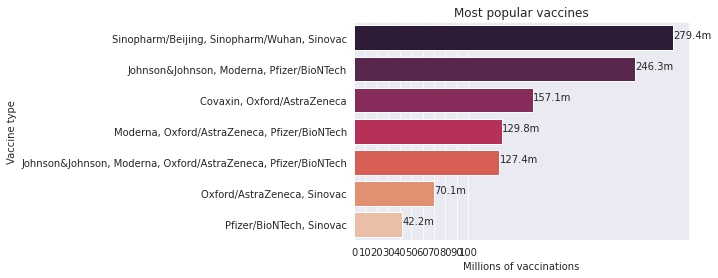

In [13]:
sns.set_style('darkgrid')
ax = sns.barplot(x = total_vaccines.iloc[:7,:]['total_vaccinations'] , y =total_vaccines.iloc[:7,:].index, palette="rocket")
ax.set_xlabel('Millions of vaccinations')
ax.set_ylabel('Vaccine type')
ax.set_title('Most popular vaccines')
plt.xticks(ticks = [0,10000000,20000000,30000000,40000000,50000000,60000000,70000000,80000000,90000000,100000000],labels= [0,10,20,30,40,50,60,70,80,90,100])
show_values_on_bars(ax,h_v = 'h', space = 0.7)

In [14]:
latest_data[latest_data['vaccines'] == 'Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Japan,Pfizer/BioNTech,4197463.000000,3091529.000000,1105934.000000,2021-05-06 00:00:00
Slovakia,Pfizer/BioNTech,1740460.000000,1176143.000000,564317.000000,2021-05-06 00:00:00
Qatar,Pfizer/BioNTech,1732471.000000,1080415.000000,652056.000000,2021-05-06 00:00:00
Kuwait,Pfizer/BioNTech,1440000.000000,822000.000000,38000.000000,2021-05-06 00:00:00
New Zealand,Pfizer/BioNTech,304900.000000,217603.000000,87297.000000,2021-05-04 00:00:00
Cyprus,Pfizer/BioNTech,287816.000000,218323.000000,69463.000000,2021-05-01 00:00:00
Aruba,Pfizer/BioNTech,79553.000000,55371.000000,24182.000000,2021-05-06 00:00:00
Gibraltar,Pfizer/BioNTech,72674.000000,37988.000000,34686.000000,2021-05-06 00:00:00
Bermuda,Pfizer/BioNTech,55904.000000,32129.000000,23775.000000,2021-04-26 00:00:00


In [15]:
latest_data[latest_data['vaccines'] == 'Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Kazakhstan,Sputnik V,2025911.000000,1565681.000000,460230.000000,2021-05-05 00:00:00
Belarus,Sputnik V,328500.000000,244000.000000,84500.000000,2021-04-23 00:00:00
Venezuela,Sputnik V,250000.000000,250000.000000,0.000000,2021-04-12 00:00:00
Guinea,Sputnik V,150799.000000,97511.000000,53288.000000,2021-05-05 00:00:00
Paraguay,Sputnik V,143441.000000,131013.000000,12428.000000,2021-05-02 00:00:00
Algeria,Sputnik V,75000.000000,0.000000,0.000000,2021-02-19 00:00:00
Syria,Sputnik V,2500.000000,2500.000000,0.000000,2021-04-08 00:00:00


In [16]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Bangladesh,Oxford/AstraZeneca,9133278.000000,5819854.000000,3313424.000000,2021-05-06 00:00:00
Nigeria,Oxford/AstraZeneca,1266742.000000,1266742.000000,0.000000,2021-05-05 00:00:00
Ethiopia,Oxford/AstraZeneca,1215934.000000,0.000000,0.000000,2021-05-05 00:00:00
Myanmar,Oxford/AstraZeneca,1040000.000000,1000000.000000,40000.000000,2021-03-31 00:00:00
Ghana,Oxford/AstraZeneca,849527.000000,849527.000000,0.000000,2021-04-30 00:00:00
Vietnam,Oxford/AstraZeneca,675956.000000,675956.000000,0.000000,2021-05-05 00:00:00
Uzbekistan,Oxford/AstraZeneca,600369.000000,600369.000000,0.000000,2021-04-27 00:00:00
Bhutan,Oxford/AstraZeneca,481107.000000,481107.000000,0.000000,2021-05-06 00:00:00
Angola,Oxford/AstraZeneca,456349.000000,456349.000000,0.000000,2021-04-23 00:00:00


In [17]:
latest_data[latest_data['vaccines'] == 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
United Kingdom,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",51225890.000000,34934171.000000,16291719.000000,2021-05-05 00:00:00
England,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",42864836.000000,29232101.000000,13632735.000000,2021-05-05 00:00:00
Canada,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",14924694.000000,13728528.000000,1196166.000000,2021-05-06 00:00:00
Scotland,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",4260931.000000,2860635.000000,1400296.000000,2021-05-05 00:00:00
Portugal,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",3675613.000000,2692633.000000,982958.000000,2021-05-06 00:00:00
Greece,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",3424468.000000,2333921.000000,1090547.000000,2021-05-06 00:00:00
Wales,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",2683297.000000,1884372.000000,798925.000000,2021-05-05 00:00:00
Denmark,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",2155301.000000,1415117.000000,740184.000000,2021-05-04 00:00:00
Finland,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",1990774.000000,1804953.000000,185821.000000,2021-05-05 00:00:00


In [18]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Kenya,"Oxford/AstraZeneca, Sputnik V",853081.000000,853081.000000,0.000000,2021-04-28 00:00:00
Nicaragua,"Oxford/AstraZeneca, Sputnik V",135130.000000,135130.000000,0.000000,2021-04-24 00:00:00


In [19]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Serbia,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",3715103.000000,2088102.000000,1627001.000000,2021-05-06 00:00:00
Mongolia,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",1946350.000000,1356678.000000,589672.000000,2021-05-06 00:00:00
Bahrain,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",1334658.000000,772205.000000,562453.000000,2021-05-06 00:00:00
Lebanon,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",509705.000000,325383.000000,184322.000000,2021-05-06 00:00:00
Montenegro,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",94291.000000,65390.000000,28901.000000,2021-05-06 00:00:00


In [20]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Brazil,"Oxford/AstraZeneca, Sinovac",46542392.000000,31504414.000000,15037978.000000,2021-05-06 00:00:00
Indonesia,"Oxford/AstraZeneca, Sinovac",21367754.000000,13028699.000000,8339055.000000,2021-05-06 00:00:00
Philippines,"Oxford/AstraZeneca, Sinovac",2129185.000000,1786480.000000,342705.000000,2021-05-05 00:00:00
Thailand,"Oxford/AstraZeneca, Sinovac",1651782.000000,1201258.000000,450524.000000,2021-05-06 00:00:00
Azerbaijan,"Oxford/AstraZeneca, Sinovac",1593883.000000,992252.000000,601631.000000,2021-05-06 00:00:00


In [21]:
latest_data[latest_data['vaccines'] == 'Sinopharm/Beijing'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Zimbabwe,Sinopharm/Beijing,607355.000000,478174.000000,129181.000000,2021-05-06 00:00:00
Senegal,Sinopharm/Beijing,421993.000000,421993.000000,0.000000,2021-05-06 00:00:00
Equatorial Guinea,Sinopharm/Beijing,75518.000000,64646.000000,10872.000000,2021-04-28 00:00:00
Mozambique,Sinopharm/Beijing,57305.000000,57305.000000,0.000000,2021-03-23 00:00:00
Cameroon,Sinopharm/Beijing,11000.000000,11000.000000,0.000000,2021-04-29 00:00:00
Gabon,Sinopharm/Beijing,8897.000000,6895.000000,2002.000000,2021-04-23 00:00:00
Mauritania,Sinopharm/Beijing,7038.000000,7038.000000,0.000000,2021-04-18 00:00:00
Niger,Sinopharm/Beijing,1366.000000,1366.000000,0.000000,2021-04-17 00:00:00


In [22]:
latest_data[latest_data['vaccines'] == 'Moderna, Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Israel,"Moderna, Pfizer/BioNTech",10489167.000000,5417346.000000,5071821.000000,2021-05-06 00:00:00
Switzerland,"Moderna, Pfizer/BioNTech",2791978.000000,1841984.000000,949994.000000,2021-05-02 00:00:00
Singapore,"Moderna, Pfizer/BioNTech",2213888.000000,1364124.000000,849764.000000,2021-04-18 00:00:00
Curacao,"Moderna, Pfizer/BioNTech",106971.000000,76031.000000,30940.000000,2021-05-06 00:00:00
Faeroe Islands,"Moderna, Pfizer/BioNTech",21128.000000,14743.000000,6385.000000,2021-05-06 00:00:00
Liechtenstein,"Moderna, Pfizer/BioNTech",12998.000000,8815.000000,4183.000000,2021-05-02 00:00:00


In [23]:
latest_data[latest_data['vaccines'] == 'Pfizer/BioNTech, Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Turkey,"Pfizer/BioNTech, Sinovac",24467719.000000,14391595.000000,10076124.000000,2021-05-06 00:00:00
Chile,"Pfizer/BioNTech, Sinovac",15296805.000000,8303682.000000,6993123.000000,2021-05-05 00:00:00
Hong Kong,"Pfizer/BioNTech, Sinovac",1623981.000000,1021217.000000,602764.000000,2021-05-06 00:00:00
Malaysia,"Pfizer/BioNTech, Sinovac",1500202.000000,914663.000000,585539.000000,2021-05-03 00:00:00


In [24]:
latest_data[latest_data['vaccines'] == 'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
China,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",297734000.000000,0.000000,0.000000,2021-05-06 00:00:00


In [25]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Saudi Arabia,"Oxford/AstraZeneca, Pfizer/BioNTech",10065924.000000,0.000000,0.000000,2021-05-06 00:00:00
South Korea,"Oxford/AstraZeneca, Pfizer/BioNTech",4005806.000000,3608616.000000,397190.000000,2021-05-06 00:00:00
Sweden,"Oxford/AstraZeneca, Pfizer/BioNTech",3563609.000000,2769411.000000,794198.000000,2021-05-06 00:00:00
Australia,"Oxford/AstraZeneca, Pfizer/BioNTech",2473529.000000,159294.000000,0.000000,2021-05-06 00:00:00
Costa Rica,"Oxford/AstraZeneca, Pfizer/BioNTech",950252.000000,605099.000000,345153.000000,2021-05-03 00:00:00
Panama,"Oxford/AstraZeneca, Pfizer/BioNTech",731189.000000,496131.000000,235058.000000,2021-05-06 00:00:00
Slovenia,"Oxford/AstraZeneca, Pfizer/BioNTech",702666.000000,463252.000000,239414.000000,2021-05-06 00:00:00
Oman,"Oxford/AstraZeneca, Pfizer/BioNTech",315691.000000,253000.000000,62691.000000,2021-04-28 00:00:00
Jersey,"Oxford/AstraZeneca, Pfizer/BioNTech",88404.000000,52891.000000,35513.000000,2021-05-02 00:00:00


In [26]:
latest_data[latest_data['vaccines'] == 'Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,


In [27]:
latest_data[latest_data['vaccines'] == 'Moderna'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,


In [28]:
latest_data[latest_data['vaccines'] == 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Hungary,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",6468466.000000,4153038.000000,2315428.000000,2021-05-05 00:00:00


In [29]:
latest_data[latest_data['vaccines'] == 'Covaxin, Oxford/AstraZeneca'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
India,"Covaxin, Oxford/AstraZeneca",162603603.000000,131058890.000000,31544713.000000,2021-05-06 00:00:00


In [30]:
latest_data[latest_data['vaccines'] == 'Pfizer/BioNTech, Sinopharm/Beijing'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Jordan,"Pfizer/BioNTech, Sinopharm/Beijing",1091048.000000,805020.000000,286028.000000,2021-05-04 00:00:00
Macao,"Pfizer/BioNTech, Sinopharm/Beijing",112748.000000,74059.000000,38831.000000,2021-05-06 00:00:00


In [31]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
North Macedonia,"Oxford/AstraZeneca, Pfizer/BioNTech, Sputnik V",74076.000000,74076.000000,0.000000,2021-05-05 00:00:00


In [32]:
latest_data[latest_data['vaccines'] == 'Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Laos,"Sinopharm/Beijing, Sputnik V",184387.000000,126072.000000,58315.000000,2021-04-26 00:00:00
Kyrgyzstan,"Sinopharm/Beijing, Sputnik V",27858.000000,27000.000000,858.000000,2021-04-28 00:00:00


In [33]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sinopharm/Beijing'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Morocco,"Oxford/AstraZeneca, Sinopharm/Beijing",9680954.000000,5334087.000000,4346867.000000,2021-05-05 00:00:00
Nepal,"Oxford/AstraZeneca, Sinopharm/Beijing",2091511.000000,2091511.000000,0.000000,2021-04-28 00:00:00
Sri Lanka,"Oxford/AstraZeneca, Sinopharm/Beijing",1088093.000000,928107.000000,159986.000000,2021-05-06 00:00:00
Egypt,"Oxford/AstraZeneca, Sinopharm/Beijing",660000.000000,660000.000000,0.000000,2021-04-18 00:00:00
Iraq,"Oxford/AstraZeneca, Sinopharm/Beijing",298377.000000,298377.000000,0.000000,2021-04-23 00:00:00
Seychelles,"Oxford/AstraZeneca, Sinopharm/Beijing",127721.000000,68045.000000,59676.000000,2021-05-03 00:00:00
Namibia,"Oxford/AstraZeneca, Sinopharm/Beijing",20005.000000,18837.000000,1168.000000,2021-04-28 00:00:00


In [34]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Argentina,"Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V",8591061.000000,7399515.000000,1191546.000000,2021-05-06 00:00:00
Iran,"Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V",1314641.000000,1083138.000000,231503.000000,2021-05-04 00:00:00
Bolivia,"Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V",878563.000000,637694.000000,240869.000000,2021-05-03 00:00:00


In [35]:
latest_data[latest_data['vaccines'] == 'EpiVacCorona, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
Russia,"EpiVacCorona, Sputnik V",21177713.000000,12893563.000000,8284150.000000,2021-05-06 00:00:00


In [36]:
latest_data[latest_data['vaccines'] == 'Johnson&Johnson'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
South Africa,Johnson&Johnson,366101.000000,366101.000000,366101.000000,2021-05-05 00:00:00


In [37]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
country,,,,,
United Arab Emirates,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V",10907264.000000,5081853.000000,3836521.000000,2021-05-06 00:00:00


In [38]:
# Sns settings
c = '#386B7F'
sns.set_style('darkgrid')

In [39]:
latest_data[['people_fully_vaccinated_per_hundred','people_fully_vaccinated', 'date' ]].sort_values(by='people_fully_vaccinated_per_hundred', ascending = False).head(30).style.background_gradient(cmap = 'Blues')

,people_fully_vaccinated_per_hundred,people_fully_vaccinated,date
country,,,
Gibraltar,102.950000,34686.000000,2021-05-06 00:00:00
Seychelles,60.680000,59676.000000,2021-05-03 00:00:00
Israel,58.600000,5071821.000000,2021-05-06 00:00:00
Falkland Islands,50.960000,1775.000000,2021-04-14 00:00:00
Cayman Islands,49.470000,32511.000000,2021-05-05 00:00:00
United Arab Emirates,38.790000,3836521.000000,2021-05-06 00:00:00
Bermuda,38.180000,23775.000000,2021-04-26 00:00:00
Chile,36.580000,6993123.000000,2021-05-05 00:00:00
Jersey,35.140000,35513.000000,2021-05-02 00:00:00


In [40]:
latest_data[['people_fully_vaccinated_per_hundred', 'people_fully_vaccinated']].sort_values(by='people_fully_vaccinated', ascending = False).head(10).style.background_gradient(cmap = 'Blues')

,people_fully_vaccinated_per_hundred,people_fully_vaccinated
country,,
United States,32.570000,108926627.000000
India,2.290000,31544713.000000
United Kingdom,24.000000,16291719.000000
Brazil,7.070000,15037978.000000
England,24.220000,13632735.000000
Turkey,11.950000,10076124.000000
Mexico,6.820000,8790655.000000
Indonesia,3.050000,8339055.000000
Russia,5.680000,8284150.000000


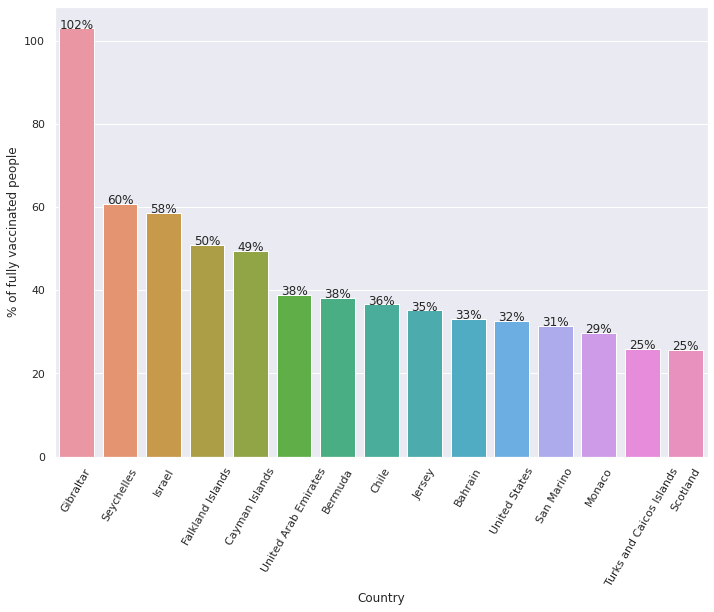

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style = 'darkgrid')
ax3 = sns.barplot(x = latest_data['people_fully_vaccinated_per_hundred'].sort_values(ascending = False).head(15).index,
                 y = latest_data['people_fully_vaccinated_per_hundred'].sort_values(ascending = False).head(15))
ax3.set_xlabel('Country')
ax3.set_ylabel('% of fully vaccinated people')
plt.xticks(rotation = 60)
show_values_on_bars(ax3, h_v = 'v')

In [42]:
def show_values_on_bars(axs, h_v="v", space=0.7):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = '{:.0f}m'.format(int(p.get_height()) / 1000000)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 2
                value = '{:.1f}m'.format(int(p.get_width()) / 1000000)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

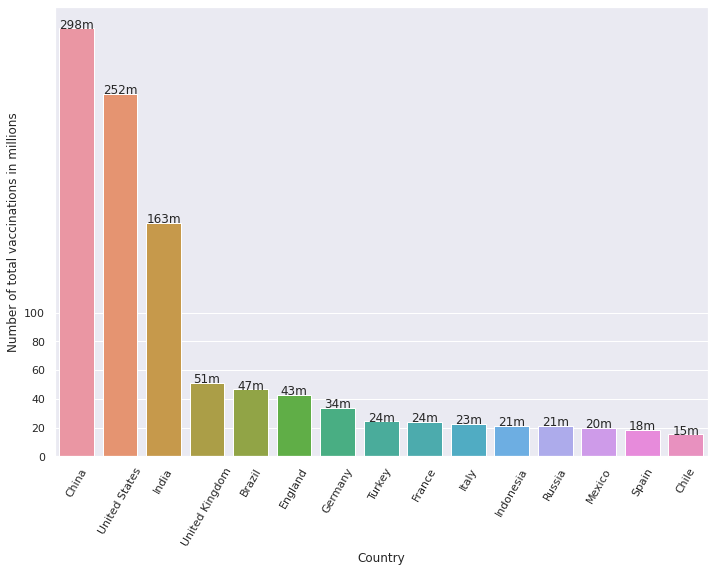

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style = 'darkgrid')
ax2 = sns.barplot(x = latest_data['total_vaccinations'].sort_values(ascending = False).head(15).index,
                 y = latest_data['total_vaccinations'].sort_values(ascending = False).head(15))
ax2.set_xlabel('Country')
ax2.set_ylabel('Number of total vaccinations in millions')
plt.yticks(ticks = [0,20000000,40000000,60000000,80000000,100000000], labels = [0,20,40,60,80,100])
plt.xticks(rotation = 60)
show_values_on_bars(ax2, h_v = 'v')

In [44]:
conditions = [(latest_data['people_fully_vaccinated_per_hundred'] <= 2.5), 
              (latest_data['people_fully_vaccinated_per_hundred'] > 2.5) & (latest_data['people_fully_vaccinated_per_hundred'] <= 5),
              (latest_data['people_fully_vaccinated_per_hundred'] > 5) & (latest_data['people_fully_vaccinated_per_hundred'] <= 7.5),
              (latest_data['people_fully_vaccinated_per_hundred'] > 7.5) & (latest_data['people_fully_vaccinated_per_hundred'] <= 10),
             (latest_data['people_fully_vaccinated_per_hundred'] > 10)]
values = ['very low','low', 'moderated', 'medium', 'high']
new_data = latest_data
new_data['vaccination_level'] = np.select(conditions, values)
new_data.head(10)

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,people_fully_vaccinated_per_hundred,vaccines,iso_code,vaccination_level
country,,,,,,,,
China,2021-05-06,297734000.0,0.0,0.0,0.00,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",CHN,very low
United States,2021-05-06,251973752.0,149462265.0,108926627.0,32.57,"Johnson&Johnson, Moderna, Pfizer/BioNTech",USA,high
India,2021-05-06,162603603.0,131058890.0,31544713.0,2.29,"Covaxin, Oxford/AstraZeneca",IND,very low
United Kingdom,2021-05-05,51225890.0,34934171.0,16291719.0,24.00,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",GBR,high
Brazil,2021-05-06,46542392.0,31504414.0,15037978.0,7.07,"Oxford/AstraZeneca, Sinovac",BRA,moderated
England,2021-05-05,42864836.0,29232101.0,13632735.0,24.22,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",OWID_ENG,high
Germany,2021-05-06,33565445.0,26220901.0,7360108.0,8.78,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",DEU,medium
Turkey,2021-05-06,24467719.0,14391595.0,10076124.0,11.95,"Pfizer/BioNTech, Sinovac",TUR,high
France,2021-05-05,23949989.0,16791193.0,7238601.0,10.62,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",FRA,high


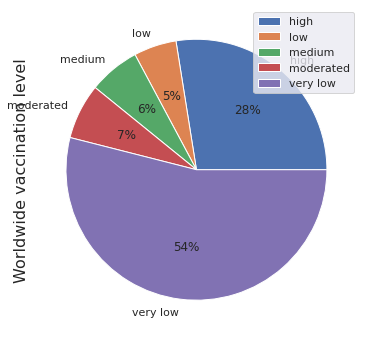

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
new_data.groupby('vaccination_level').size().plot(kind='pie', autopct='%1.0f%%', ax = ax)
ax.set_ylabel('Worldwide vaccination level', fontsize = 16)
plt.legend()
plt.show()

In [46]:
daily_data = data[['daily_vaccinations','date']].groupby('date', as_index = False).sum()
daily_data['vac_test'] = daily_data['daily_vaccinations']
daily_data.head(10)

,date,daily_vaccinations,vac_test
0,2020-12-15,718.0,718.0
1,2020-12-16,192366.0,192366.0
2,2020-12-17,193256.0,193256.0
3,2020-12-18,193649.0,193649.0
4,2020-12-19,193235.0,193235.0
5,2020-12-20,200354.0,200354.0
6,2020-12-21,267874.0,267874.0
7,2020-12-22,347612.0,347612.0
8,2020-12-23,391560.0,391560.0
9,2020-12-24,460850.0,460850.0


In [47]:
daily_data['year'] = daily_data['date'].dt.year
daily_data['month'] = daily_data['date'].dt.month
daily_data['day'] = daily_data['date'].dt.day
daily_data.tail(10)

,date,daily_vaccinations,vac_test,year,month,day
133,2021-04-27,18414295.0,18414295.0,2021,4,27
134,2021-04-28,19215486.0,19215486.0,2021,4,28
135,2021-04-29,19573439.0,19573439.0,2021,4,29
136,2021-04-30,20398287.0,20398287.0,2021,4,30
137,2021-05-01,20334355.0,20334355.0,2021,5,1
138,2021-05-02,19995640.0,19995640.0,2021,5,2
139,2021-05-03,19292226.0,19292226.0,2021,5,3
140,2021-05-04,18816094.0,18816094.0,2021,5,4
141,2021-05-05,18135652.0,18135652.0,2021,5,5
142,2021-05-06,14911882.0,14911882.0,2021,5,6


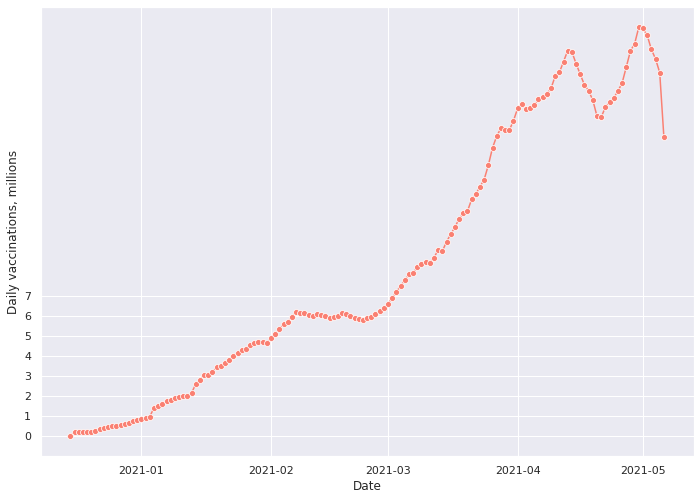

In [48]:
ax = sns.lineplot(x = daily_data['date'], y = daily_data['daily_vaccinations'], color='salmon', marker='o')
ax.set_xlabel('Date')
plt.yticks(ticks = [0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000], labels = [0, 1, 2, 3, 4, 5, 6, 7])
ax.set_ylabel('Daily vaccinations, millions')
plt.show()

In [49]:
jan = daily_data[daily_data['month'] == 1]
feb = daily_data[daily_data['month'] == 2]
mar = daily_data[daily_data['month'] == 3]

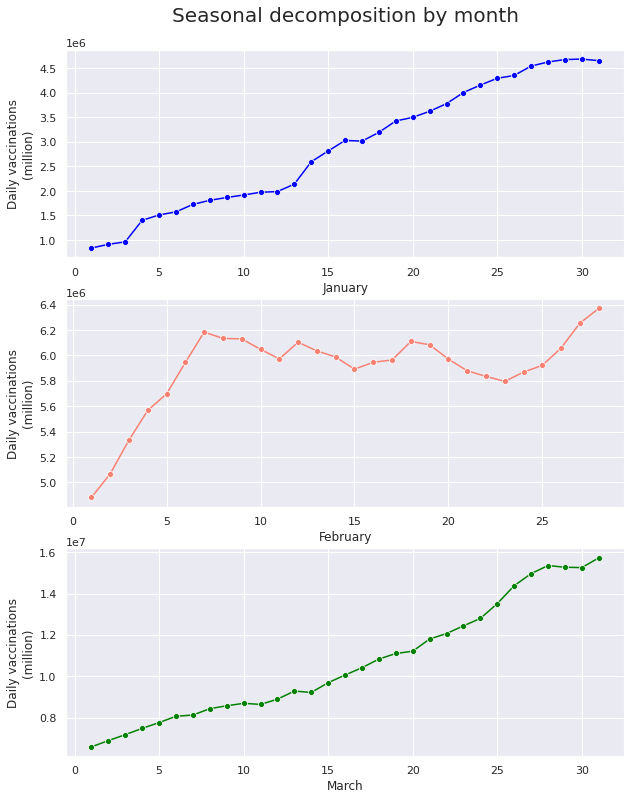

In [50]:
# define figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,13))
# creating subplot 1
sns.lineplot(x = jan['day'], y = jan['daily_vaccinations'], color='blue', marker='o', ax=ax1)
ax1.set(xlabel = 'January', ylabel = 'Daily vaccinations\n(million)')
ax1.set_title('Seasonal decomposition by month\n', fontsize = 20)
# creating subplot 2
sns.lineplot(x = feb['day'], y = feb['daily_vaccinations'], color='salmon', marker='o', ax=ax2)
ax2.set(xlabel = 'February', ylabel = 'Daily vaccinations\n(million)')
# creating subplot 3
sns.lineplot(x = mar['day'], y = mar['daily_vaccinations'], color='green', marker='o', ax=ax3)
ax3.set(xlabel = 'March', ylabel = 'Daily vaccinations\n(million)')

plt.show()

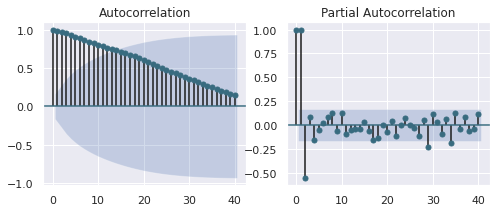

In [51]:
plt.figure(figsize = (8,3))
plt.subplot(121); plot_acf(daily_data['daily_vaccinations'], lags = 40, ax = plt.gca(), color = c)
plt.subplot(122); plot_pacf(daily_data['daily_vaccinations'], lags = 40,ax = plt.gca(), color = c)
plt.show()

In [52]:
adfuller(daily_data['daily_vaccinations'])

(-1.382061619691447,
 0.5908451526726972,
 6,
 136,
 {'1%': -3.4793722137854926,
  '10%': -2.578233635380623,
  '5%': -2.8830370378332995},
 3606.7581821959748)

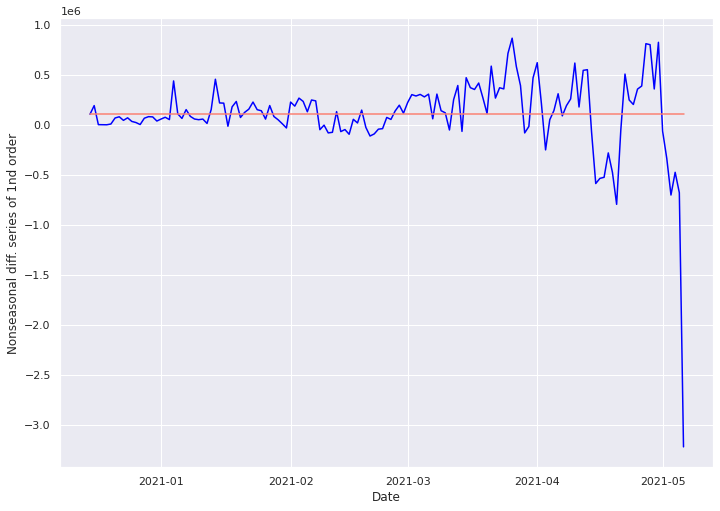

(-1.120870149966403,
 0.7066777817249376,
 14,
 128,
 {'1%': -3.4825006939887997,
  '10%': -2.578960197753906,
  '5%': -2.884397984161377},
 3605.794044056918)

In [53]:
daily_data['diff1'] = daily_data['daily_vaccinations'].diff()
daily_data['diff1'] = daily_data['diff1'].fillna(daily_data['diff1'].mean())
ax = sns.lineplot(x = daily_data['date'], y = daily_data['diff1'], color='blue')
sns.lineplot(x = daily_data['date'], y = daily_data['diff1'].mean(), color='salmon')
plt.xlabel('Date')
plt.ylabel('Nonseasonal diff. series of 1nd order')
plt.show()
adfuller(daily_data.diff1)

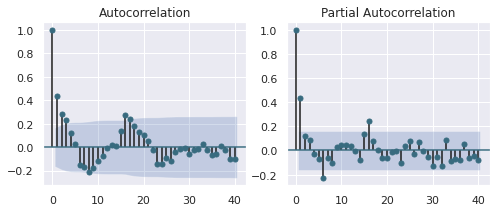

In [54]:
plt.figure(figsize = (8,3))
plt.subplot(121); plot_acf(daily_data['diff1'], lags = 40, ax = plt.gca(), color = c)
plt.subplot(122); plot_pacf(daily_data['diff1'], lags = 40,ax = plt.gca(), color = c)
plt.show()

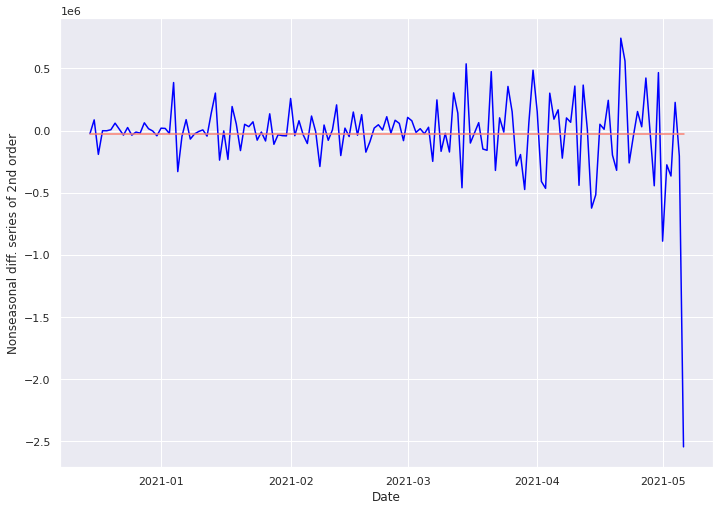

(-4.800417052579001,
 5.428611581498604e-05,
 14,
 128,
 {'1%': -3.4825006939887997,
  '10%': -2.578960197753906,
  '5%': -2.884397984161377},
 3589.3830109352707)

In [55]:
daily_data['diff2'] = daily_data['diff1'].diff()
daily_data['diff2'] = daily_data['diff2'].fillna(daily_data['diff2'].mean())
ax = sns.lineplot(x = daily_data['date'], y = daily_data['diff2'], color='blue')
sns.lineplot(x = daily_data['date'], y = daily_data['diff2'].mean(), color='salmon')
plt.xlabel('Date')
plt.ylabel('Nonseasonal diff. series of 2nd order')
plt.show()
adfuller(daily_data.diff2)

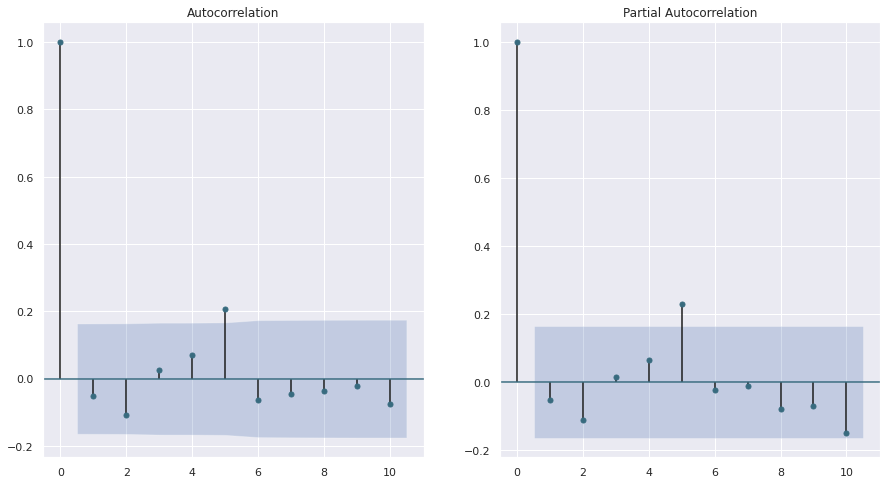

In [56]:
plt.figure(figsize = (15,8))
plt.subplot(121); plot_acf(daily_data['diff2'], lags = 10, ax = plt.gca(), color = c)
plt.subplot(122); plot_pacf(daily_data['diff2'], lags = 10,ax = plt.gca(), color = c)
plt.show()

# ARIMA

2904     6.084432
2905     6.476605
2906     6.861742
2907     7.193121
2908     7.495242
2909     7.778761
2910     8.081245
2911     8.477054
2912     8.949424
2913     9.317502
2914     9.558033
2915     9.773510
2916     9.984908
2917    10.203265
2918    10.507383
2919    10.901038
2920    11.236151
2921    11.477423
2922    11.735961
2923    12.014676
2924    12.270158
2925    12.542313
2926    12.824332
2927    13.054411
2928    13.231659
2929    13.411839
2930    13.637606
2931    13.941377
2932    14.349391
2933    14.756194
2934    15.088192
2935    15.402744
2936    15.717482
2937    16.087489
2938    16.568655
2939    17.155820
2940    17.865238
2941    18.470286
2942    18.872496
2943    19.215929
2944    19.540403
2945    19.873922
Name: predicted_mean, dtype: float64


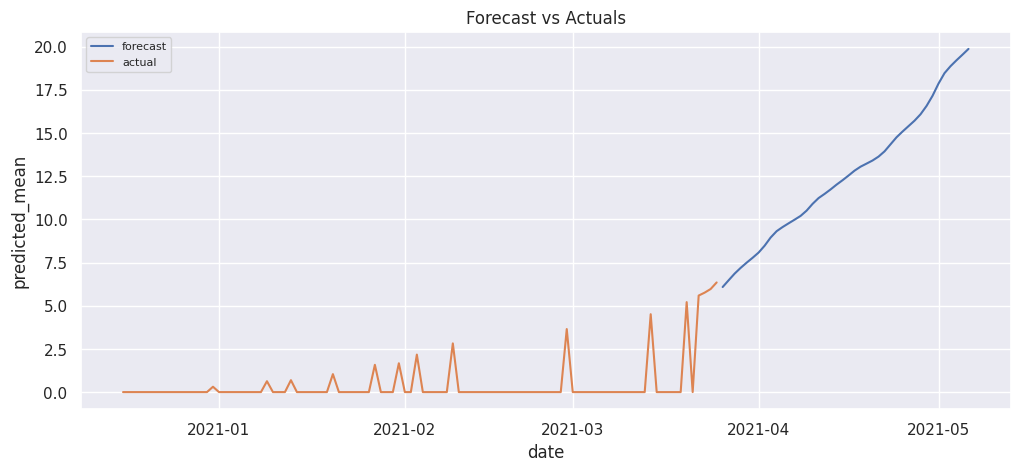

In [57]:
#df_gm[df_gm['iso_code'].isin([cntry])].sort_values(by="date")[['date',"people_fully_vaccinated_per_hundred"]]
train = data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations_per_hundred'][:100]
test = data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations_per_hundred'][100:]
model = ARIMA(data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations_per_hundred'][:200], order = (1,1,1))
model = model.fit()
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start, end=end, typ = 'levels')
print(pred)
plt.figure(figsize=(12,5), dpi=100)
ax = sns.lineplot(x=data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['date'], y = pred, label='forecast')
sns.lineplot(x=data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['date'], y = data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations_per_hundred'][:100], label='actual', ax=ax)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [58]:
mean_squared_error(test, pred, squared = False)

0.6139603716431402

In [59]:
test.mean()

13.153095238095236

In [60]:
mean_absolute_percentage_error(test,pred)

0.04731443174333693

In [61]:
from sklearn.metrics import r2_score
r2_score(test, pred)

0.975600809209682

In [62]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(test, pred))

0.5820140181663599


In [63]:
from sklearn.metrics import median_absolute_error
print(median_absolute_error(test, pred))

0.549417150835033


In [64]:
from math import sqrt
rmse = sqrt(mean_squared_error(test, pred))
print(rmse)

0.6139603716431402
